# Regularization Workshop

## Introduction

Welcome to this interactive workshop on regularization techniques in machine learning! In this 1.5-hour session, we'll cover the fundamentals of regularization, the bias-variance tradeoff, and specific regularization methods like Ridge, Lasso, and ElasticNet regression.

### Workshop Outline
1. Bias-Variance Tradeoff
2. What is Regularization?
3. Ridge Regression (L2 Regularization)
4. Lasso Regression (L1 Regularization)
5. Why Lasso Creates Sparsity
6. ElasticNet Regression

Let's get started by importing the necessary libraries.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression, load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import warnings

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

# 1. Bias-Variance Tradeoff

## Why we need to study Bias and Variance

When building machine learning models, we aim to create models that can generalize well to unseen data. Two primary sources of error prevent perfect generalization:

- **Bias**: How far off the model's predictions are from the true values
- **Variance**: How much the model's predictions fluctuate for different training sets

Understanding the bias-variance tradeoff is crucial for building models that perform well on new data.

## Expected Value and Variance

Let's review these statistical concepts:

- **Expected Value (Mean)**: The average value of a random variable
- **Variance**: A measure of how spread out the values are from the mean

In machine learning, we're concerned with the expected value and variance of our model's predictions.

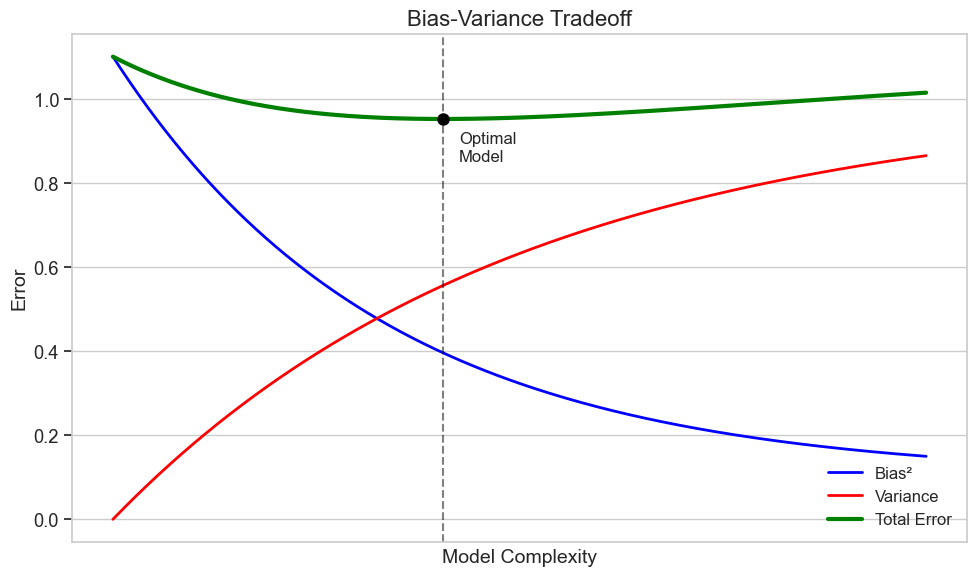

In [2]:
# Create a figure to illustrate bias-variance tradeoff
plt.figure(figsize=(10, 6))

# Define the range of model complexity
complexity = np.linspace(0, 10, 1000)

# Define bias, variance and total error curves
bias = np.exp(-0.3*complexity) + 0.1
variance = 1 - np.exp(-0.2*complexity) 
total_error = bias + variance

# Plot the curves
plt.plot(complexity, bias, 'b-', label='Bias²', linewidth=2)
plt.plot(complexity, variance, 'r-', label='Variance', linewidth=2)
plt.plot(complexity, total_error, 'g-', label='Total Error', linewidth=3)

# Find and mark optimal complexity
optimal_idx = np.argmin(total_error)
optimal_complexity = complexity[optimal_idx]
min_error = total_error[optimal_idx]

plt.axvline(x=optimal_complexity, color='k', linestyle='--', alpha=0.5)
plt.plot(optimal_complexity, min_error, 'ko', markersize=8)

# Add labels, title and legend
plt.xlabel('Model Complexity', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Bias-Variance Tradeoff', fontsize=16)
plt.legend(fontsize=12)
plt.xticks([])
plt.annotate('Underfitting\n(High Bias)', xy=(1, 1.2), fontsize=12)
plt.annotate('Optimal\nModel', xy=(optimal_complexity+0.2, min_error-0.1), fontsize=12)
plt.annotate('Overfitting\n(High Variance)', xy=(8, 1.2), fontsize=12)

plt.tight_layout()
plt.show()

### 📊 Interactive Demonstration: Polynomial Regression and Bias-Variance

Let's see the bias-variance tradeoff in action by fitting polynomial models of different degrees to a simple dataset:

In [3]:
# Generate synthetic data
def true_function(x):
    return np.sin(1.5 * np.pi * x)

# Generate data with noise
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_function(X) + np.random.normal(0, 0.1, size=n_samples)

# Create test points for smooth curve visualization
X_test = np.linspace(0, 1, 1000)
y_true = true_function(X_test)

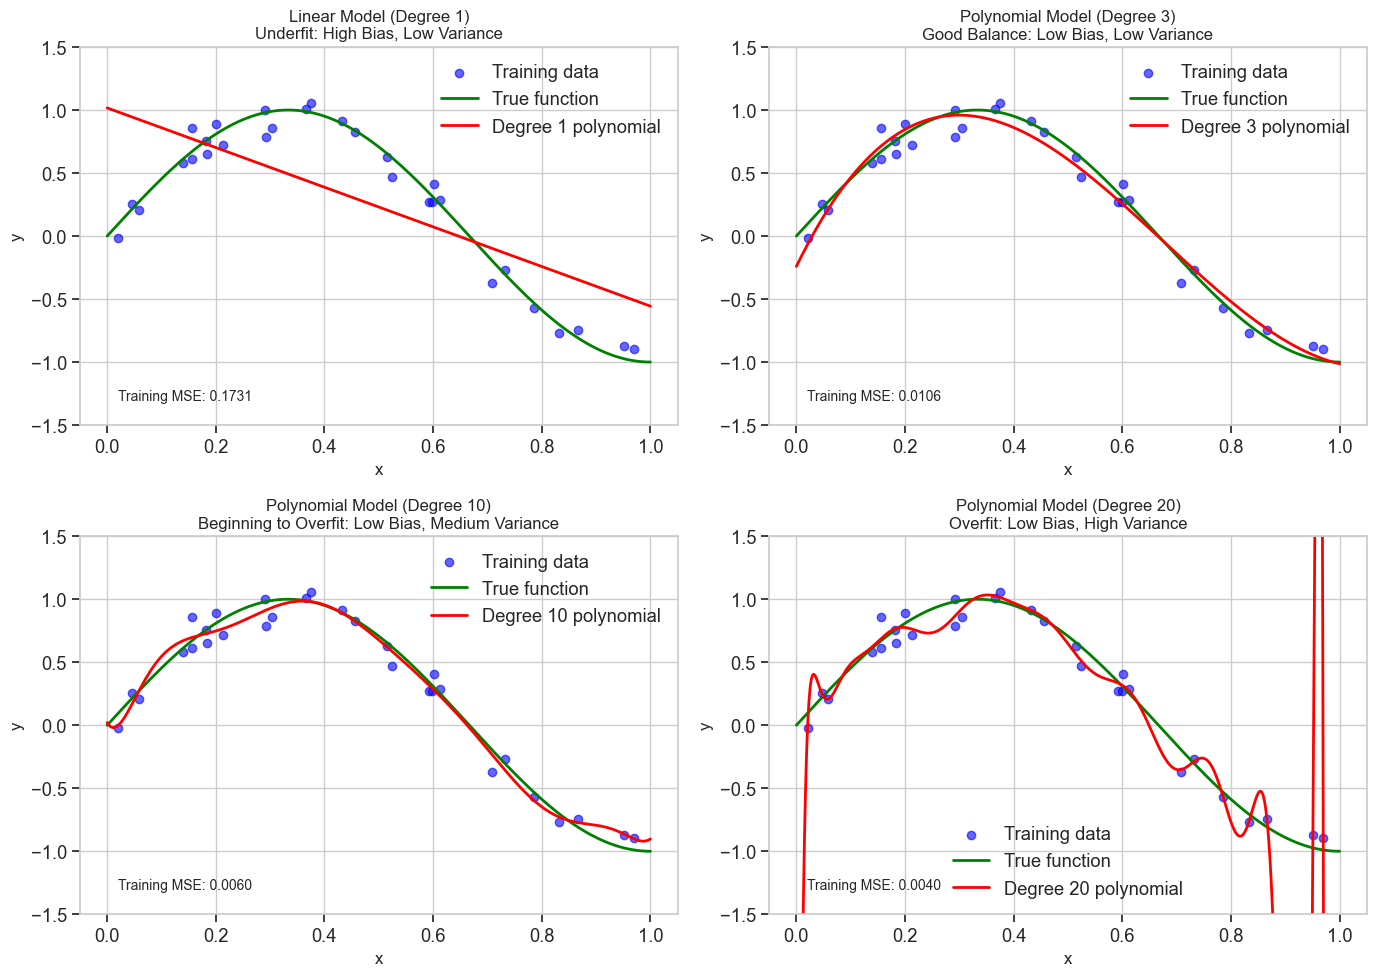

In [4]:
# Function to fit polynomial regression
def fit_polynomial(degree, X_train, y_train, X_test):
    # Create polynomial features
    X_poly_train = np.vander(X_train, degree+1, increasing=True)
    X_poly_test = np.vander(X_test, degree+1, increasing=True)
    
    # Fit linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Predict
    y_pred = model.predict(X_poly_test)
    train_pred = model.predict(X_poly_train)
    train_mse = mean_squared_error(y_train, train_pred)
    
    return y_pred, train_mse

# Plot models of different complexity
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
degrees = [1, 3, 10, 20]

for i, degree in enumerate(degrees):
    ax = axes[i]
    y_pred, train_mse = fit_polynomial(degree, X, y, X_test)
    
    # Plot the data points, true function, and prediction
    ax.scatter(X, y, color='blue', alpha=0.6, label='Training data')
    ax.plot(X_test, y_true, 'g-', label='True function', linewidth=2)
    ax.plot(X_test, y_pred, 'r-', label=f'Degree {degree} polynomial', linewidth=2)
    
    # Add information about the model
    if degree == 1:
        ax.set_title(f'Linear Model (Degree {degree})\nUnderfit: High Bias, Low Variance', fontsize=12)
    elif degree == 3:
        ax.set_title(f'Polynomial Model (Degree {degree})\nGood Balance: Low Bias, Low Variance', fontsize=12)
    elif degree == 10:
        ax.set_title(f'Polynomial Model (Degree {degree})\nBeginning to Overfit: Low Bias, Medium Variance', fontsize=12)
    else:
        ax.set_title(f'Polynomial Model (Degree {degree})\nOverfit: Low Bias, High Variance', fontsize=12)
    
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.legend(loc='best')
    ax.text(0.02, -1.3, f'Training MSE: {train_mse:.4f}', fontsize=10)

plt.tight_layout()
plt.show()

### Key Takeaways from Bias-Variance Tradeoff

- **Low complexity models** (e.g., linear regression) tend to have high bias but low variance
- **High complexity models** (e.g., high-degree polynomials) tend to have low bias but high variance
- **Overfitting**: Model performs well on training data but poorly on unseen data due to high variance
- **Underfitting**: Model performs poorly on both training and test data due to high bias
- The goal is to find the **sweet spot** with the optimal complexity that minimizes total error

This is exactly where regularization comes in - it helps us manage this tradeoff!

# 2. What is Regularization?

## Bias-Variance Decomposition

As we've seen, the expected test error can be decomposed into bias, variance, and irreducible error components. Regularization techniques help us manage this tradeoff by adding constraints to our model.

## Diagram: How Regularization Works

Regularization works by adding a penalty term to the loss function:

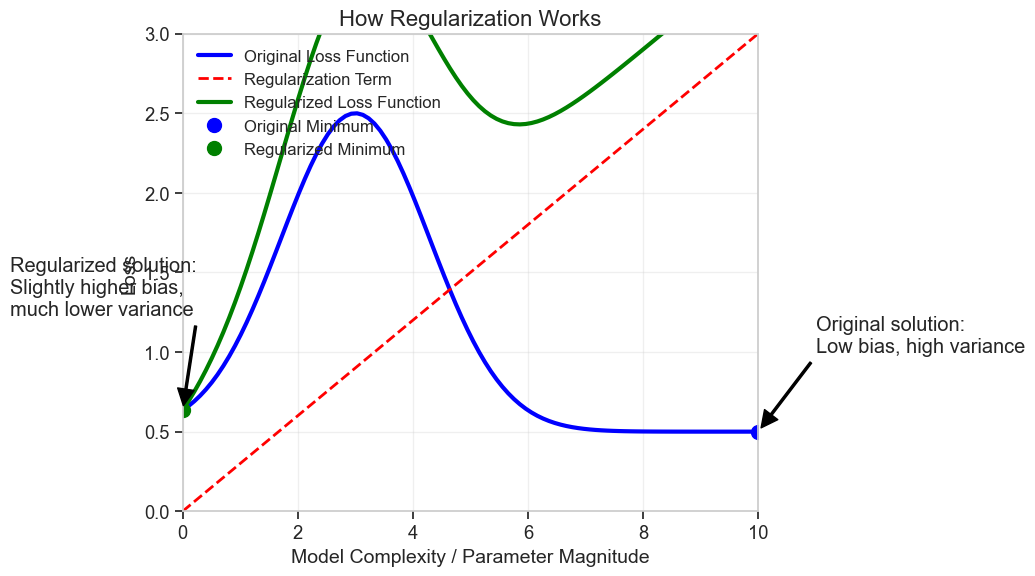

In [5]:
# Create a diagram showing regularization concept
plt.figure(figsize=(12, 6))

# Define the components
x = np.linspace(0, 10, 100)

# Loss function
loss = 2 * np.exp(-0.3*(x-3)**2) + 0.5

# Regularization term
reg_term = 0.3 * x

# Regularized loss
reg_loss = loss + reg_term

# Plot
plt.plot(x, loss, 'b-', linewidth=3, label='Original Loss Function')
plt.plot(x, reg_term, 'r--', linewidth=2, label='Regularization Term')
plt.plot(x, reg_loss, 'g-', linewidth=3, label='Regularized Loss Function')

# Mark minimum points
min_loss_idx = np.argmin(loss)
min_reg_loss_idx = np.argmin(reg_loss)

plt.plot(x[min_loss_idx], loss[min_loss_idx], 'bo', markersize=10, label='Original Minimum')
plt.plot(x[min_reg_loss_idx], reg_loss[min_reg_loss_idx], 'go', markersize=10, label='Regularized Minimum')

# Annotations
plt.annotate('Original solution:\nLow bias, high variance', 
             xy=(x[min_loss_idx], loss[min_loss_idx]), 
             xytext=(x[min_loss_idx]+1, loss[min_loss_idx]+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.annotate('Regularized solution:\nSlightly higher bias,\nmuch lower variance', 
             xy=(x[min_reg_loss_idx], reg_loss[min_reg_loss_idx]), 
             xytext=(x[min_reg_loss_idx]-3, reg_loss[min_reg_loss_idx]+0.6),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.xlim(0, 10)
plt.ylim(0, 3)
plt.xlabel('Model Complexity / Parameter Magnitude', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('How Regularization Works', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## What is Regularization?

Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. This penalty discourages large coefficients, effectively reducing model complexity.

### Mathematical Formulation

For linear regression, the loss function with regularization becomes:

$$L(\hat{y}, y) + \lambda \cdot \text{Penalty}(\theta)$$

Where:
- $L(\hat{y}, y)$ is the original loss function (e.g., Mean Squared Error)
- $\lambda$ is the regularization strength (hyperparameter)
- $\text{Penalty}(\theta)$ is the regularization term applied to parameters

Different types of regularization use different penalty terms.

In [6]:
# Generate a dataset with many features but few samples (prone to overfitting)
X, y = make_regression(n_samples=50, n_features=100, noise=10, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create models
models = {
    'Linear Regression (No Regularization)': LinearRegression(),
    'Ridge Regression (L2 Regularization)': Ridge(alpha=10),
    'Lasso Regression (L1 Regularization)': Lasso(alpha=0.1),
    'ElasticNet (L1 + L2 Regularization)': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Store results
    results[name] = {'train_mse': train_mse, 'test_mse': test_mse}
    
    # For linear and ridge, count significant coefficients (abs > 1)
    if hasattr(model, 'coef_'):
        significant_coefs = np.sum(np.abs(model.coef_) > 1)
        results[name]['significant_coefs'] = significant_coefs

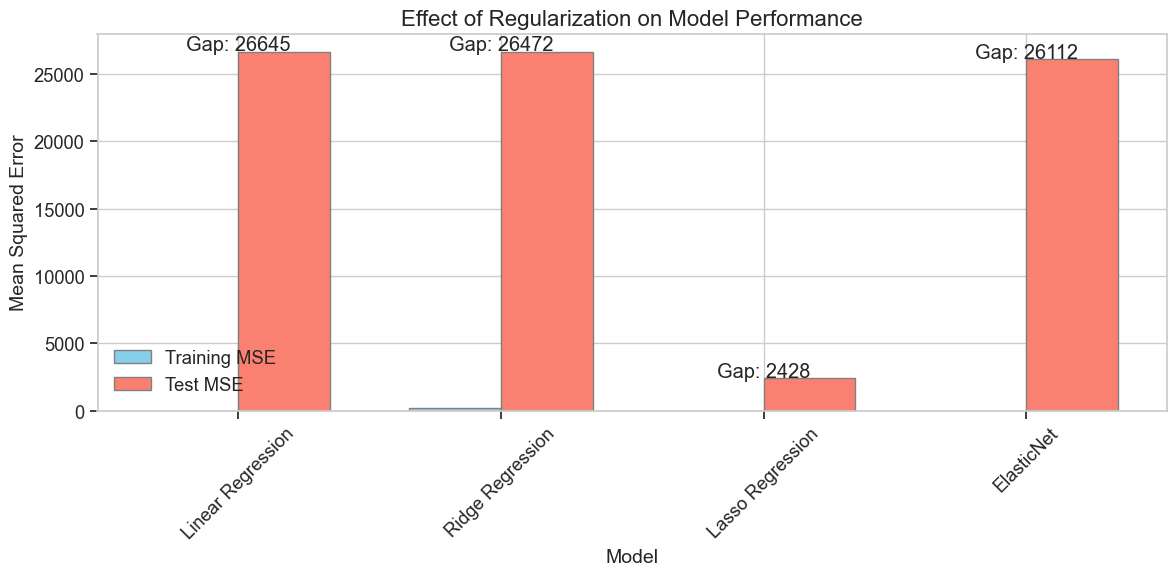

In [7]:
# Create a bar chart comparing training and test errors
plt.figure(figsize=(12, 6))

# Prepare data for plotting
models_list = list(results.keys())
train_errors = [results[model]['train_mse'] for model in models_list]
test_errors = [results[model]['test_mse'] for model in models_list]

# Set width of bars
barWidth = 0.35
r1 = np.arange(len(models_list))
r2 = [x + barWidth for x in r1]

# Create bars
plt.bar(r1, train_errors, width=barWidth, color='skyblue', edgecolor='grey', label='Training MSE')
plt.bar(r2, test_errors, width=barWidth, color='salmon', edgecolor='grey', label='Test MSE')

# Add labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Effect of Regularization on Model Performance', fontsize=16)
plt.xticks([r + barWidth/2 for r in range(len(models_list))], [m.split(' (')[0] for m in models_list], rotation=45)
plt.legend()

# Add text annotations for gap between train and test
for i in range(len(models_list)):
    gap = test_errors[i] - train_errors[i]
    plt.annotate(f'Gap: {gap:.0f}', 
                 xy=(r1[i] + barWidth/2, max(train_errors[i], test_errors[i]) + 100),
                 ha='center')

plt.tight_layout()
plt.show()

## When to use Regularization?

Regularization is particularly useful when:

1. You have **more features than samples** (p > n problem)
2. Your features are **highly correlated** (multicollinearity)
3. You observe a **large gap between training and test performance** (overfitting)
4. You want to **identify the most important features** (feature selection)
5. Your model is **too complex** for the amount of data available

Let's explore specific regularization techniques!

# 3. Ridge Regression Part I

## Types of Regularization

There are several common types of regularization:

1. **L2 Regularization (Ridge)**: Penalizes the sum of squared coefficients
2. **L1 Regularization (Lasso)**: Penalizes the sum of absolute values of coefficients
3. **Elastic Net**: Combines L1 and L2 regularization
4. **Dropout**: Randomly ignores neurons during training (for neural networks)
5. **Early Stopping**: Stops training when validation performance stops improving

Let's focus on Ridge regression first.

## Ridge Regression (L2 Regularization)

Ridge regression adds an L2 penalty term to the linear regression cost function:

$$\text{Cost} = \text{MSE} + \lambda \sum_{i=1}^{n} \theta_i^2$$

Where:
- MSE is the mean squared error of predictions
- $\lambda$ is the regularization parameter (alpha in scikit-learn)
- $\theta_i$ are the model coefficients (excluding the intercept)

The L2 penalty term encourages all coefficients to be small but non-zero.

### Key Points About Ridge Regression

- Ridge regression **shrinks all coefficients** toward zero but rarely makes them exactly zero
- The L2 penalty is proportional to the square of the coefficient values
- Geometrically, the L2 constraint forms a circle (in 2D) or hypersphere (in higher dimensions)
- Ridge works well when many features contribute a bit to the prediction (dense solution)
- Ridge is effective for dealing with multicollinearity (highly correlated features)

## Scikit-learn Implementation

Let's see Ridge regression in action with a real dataset:

In [8]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Scale the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Try different alpha values for Ridge regression
alphas = [0, 0.1, 1, 10, 100, 1000]
ridge_scores = []
ridge_models = []

for alpha in alphas:
    # Create and train a Ridge model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Store scores and model
    ridge_scores.append({'alpha': alpha, 'train_mse': train_mse, 'test_mse': test_mse})
    ridge_models.append(model)

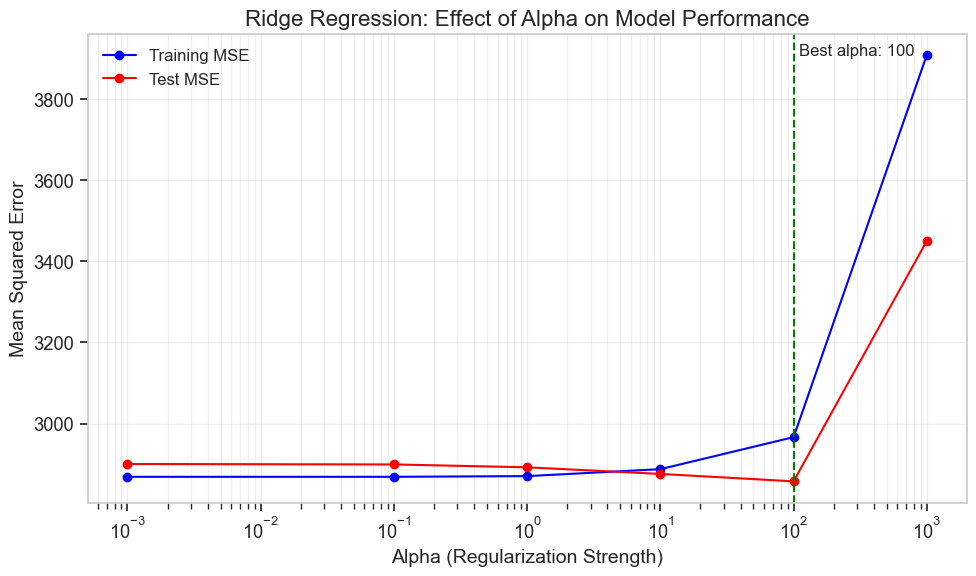

In [9]:
# Plot training and test errors for different alpha values
alphas_log = [0.001 if a == 0 else a for a in alphas]  # Replace 0 with small value for log scale

train_errors = [score['train_mse'] for score in ridge_scores]
test_errors = [score['test_mse'] for score in ridge_scores]

plt.figure(figsize=(10, 6))
plt.semilogx(alphas_log, train_errors, 'b-o', label='Training MSE')
plt.semilogx(alphas_log, test_errors, 'r-o', label='Test MSE')
plt.xlabel('Alpha (Regularization Strength)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Ridge Regression: Effect of Alpha on Model Performance', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)

# Find and mark the optimal alpha
best_alpha_idx = np.argmin(test_errors)
best_alpha = alphas[best_alpha_idx]
plt.axvline(x=best_alpha, color='g', linestyle='--')
plt.text(best_alpha*1.1, max(train_errors), f'Best alpha: {best_alpha}', fontsize=12)

plt.tight_layout()
plt.show()

# 4. Lasso Regression

## Intuition

Lasso (Least Absolute Shrinkage and Selection Operator) regression uses L1 regularization, which penalizes the sum of the absolute values of coefficients:

$$\text{Cost} = \text{MSE} + \lambda \sum_{i=1}^{n} |\theta_i|$$

The key difference from Ridge is that Lasso can drive some coefficients to exactly zero, effectively performing feature selection.

## 5️⃣ Why Lasso Regression creates Sparsity?
Lasso includes an L1 penalty which encourages many coefficients to become exactly zero, leading to simpler, interpretable models.

## Lasso Regression Key Points

- Lasso uses L1 regularization which can force some coefficients to be exactly zero
- Lasso inherently performs feature selection, which can simplify models
- Geometrically, the L1 constraint forms a diamond (in 2D) or rhomboid (in higher dimensions)
- Lasso works well when only a few features contribute significantly to the prediction (sparse solution)
- Lasso is less stable than Ridge when dealing with highly correlated features

# 6. ElasticNet Regression

## Intuition

ElasticNet combines the strengths of both L1 (Lasso) and L2 (Ridge) regularization:

$$\text{Cost} = \text{MSE} + \lambda_1 \sum_{i=1}^{n} |\theta_i| + \lambda_2 \sum_{i=1}^{n} \theta_i^2$$

In scikit-learn, this is parametrized as:

$$\text{Cost} = \text{MSE} + \alpha \cdot l1\_ratio \cdot \sum_{i=1}^{n} |\theta_i| + \alpha \cdot (1 - l1\_ratio) \cdot \sum_{i=1}^{n} \theta_i^2$$

Where:
- `alpha` controls the overall regularization strength
- `l1_ratio` controls the balance between L1 and L2 regularization (1 = pure Lasso, 0 = pure Ridge)